# Import libraries

In [13]:
import reservoirpy as rpy
from collections import defaultdict
import seaborn as sns
from reservoirpy.nodes import Ridge, Reservoir, Input
import matplotlib.pyplot as plt
# import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from sklearn.linear_model import Ridge as Ridge_sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
# import skccm as ccm
import warnings
import os

rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(23)  # make everything reproducible!

# Data preprocessing and EDA

В качестве объясняющих переменных предлагается брать:
1. Факторы формирования ликвидности банковского сектора: Факторы формирования ликвидности банковского сектора | Банк России

2.	Текущее состояние ликвидности банковского сектора: Дефицит/профицит ликвидности банковского сектора | Банк России

3.	Текущее усреднение (считается из данных о фактических остатках средств на счетах банков отсюда: Денежные средства кредитных организаций на корреспондентских счетах в Банке России | Банк России + Обязательные резервы кредитных организаций | Банк России

4.	Ожидания рынка о повышении/понижении на ближайшем заседании ЦБ. (можно посчитать из данных сайта: ROISFIX)

5.	Сезонные факторы: вторая половина декабря, первая половина января, конце квартала, конец и начало периодов усреднения (график тут: https://www.cbr.ru/oper_br/oap/), день недели, конец месяца

6.	Авторегрессионные компоненты самой VWAP ставки

7.	Рыночные данные: предыдущие закрытие стакана, объемы, волатильность и другое
Информации про обязательные резервы и периоды усреднения Обязательные резервы | Банк России. Посчитанных значений усреднения банковской системы нет, это нужно посчитать вручную.


In [14]:
# https://iss.moex.com/iss/history/engines/stock/markets/gcc/boards/gcrp/securities/RU000A0JW4Z1.json

## Факторы формирования ликвидности банк. сектора

In [15]:
def parse_cbr_data(url, reference_columns=None):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'data'})  # Уточните класс!
    
    if not table:
        raise ValueError(f"Таблица не найдена: {url}")
    
    # Заголовки колонок
    headers = [th.text.strip() for th in table.find('thead').find_all('th')]
    
    # Данные
    rows = []
    for tr in table.find('tbody').find_all('tr'):
        row = [td.text.strip() for td in tr.find_all('td')]
        rows.append(row)
    
    headers.remove('из них:')
    
    df = pd.DataFrame(rows, columns=headers)
    
    # Если заданы эталонные колонки, оставляем только их
    if reference_columns is not None:
        df = df.reindex(columns=reference_columns, fill_value=None)  # или отбрасываем лишнее
        
    return df

# Ссылки
urls = [
    "https://www.cbr.ru/statistics/flikvid/?UniDbQuery.Posted=True&UniDbQuery.From=11.01.2021&UniDbQuery.To=16.04.2025",  # Эталон
    "https://www.cbr.ru/archive/db/flikvid-old/?UniDbQuery.Posted=True&UniDbQuery.From=09.01.2017&UniDbQuery.To=31.12.2020",
    # "https://www.cbr.ru/archive/db/flikvid/?UniDbQuery.Posted=True&UniDbQuery.From=11.01.2011&UniDbQuery.To=09.01.2017"
]

# Парсим первую таблицу и получаем эталонные колонки
reference_df = parse_cbr_data(urls[0])
reference_columns = reference_df.columns.tolist()
print(f"Эталонные колонки: {reference_columns}")

# Парсим остальные таблицы, приводя колонки к эталону
dfs = [reference_df]  # Первая таблица уже в эталонном формате
for url in urls[1:]:
    df = parse_cbr_data(url, reference_columns)
    dfs.append(df)
    print(f"Загружено: {url} | Колонки: {df.columns.tolist()}")

Эталонные колонки: ['Дата', 'Изменение наличных денег в обращении (вне Банка России)', 'Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции', 'Операции Банка России на внутреннем валютном рынке', 'Операции Банка России по предоставлению и абсорбированию ликвидности', 'движение средств по государственному внутреннему долгу', 'изменение задолженности банков по депозитам Федерального казначейства', 'изменение задолженности банков по операциям репо Федерального казначейства', 'операции Минфина России по покупке (продаже) иностранной валюты на внутреннем валютном рынке*']
Загружено: https://www.cbr.ru/archive/db/flikvid-old/?UniDbQuery.Posted=True&UniDbQuery.From=09.01.2017&UniDbQuery.To=31.12.2020 | Колонки: ['Дата', 'Изменение наличных денег в обращении (вне Банка России)', 'Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции', 'Операции Банка России на внутреннем валютном рынке', 'Операции Банка Рос

In [16]:
for i, df in enumerate(dfs):
    print(f"Источник {i+1} колонки: {df.columns.tolist()}")

Источник 1 колонки: ['Дата', 'Изменение наличных денег в обращении (вне Банка России)', 'Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции', 'Операции Банка России на внутреннем валютном рынке', 'Операции Банка России по предоставлению и абсорбированию ликвидности', 'движение средств по государственному внутреннему долгу', 'изменение задолженности банков по депозитам Федерального казначейства', 'изменение задолженности банков по операциям репо Федерального казначейства', 'операции Минфина России по покупке (продаже) иностранной валюты на внутреннем валютном рынке*']
Источник 2 колонки: ['Дата', 'Изменение наличных денег в обращении (вне Банка России)', 'Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции', 'Операции Банка России на внутреннем валютном рынке', 'Операции Банка России по предоставлению и абсорбированию ликвидности', 'движение средств по государственному внутреннему долгу', 'изменен

In [17]:
final_df = pd.concat(dfs, ignore_index=True)
final_df = final_df.drop_duplicates()
final_df['Дата'] = pd.to_datetime(final_df['Дата'], format='%d.%m.%Y')  # Конвертация в datetime
final_df = final_df.sort_values('Дата')

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2046 entries, 2045 to 0
Data columns (total 9 columns):
 #   Column                                                                                            Non-Null Count  Dtype         
---  ------                                                                                            --------------  -----         
 0   Дата                                                                                              2046 non-null   datetime64[ns]
 1   Изменение наличных денег в обращении (вне Банка России)                                           2046 non-null   object        
 2   Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции  2046 non-null   object        
 3   Операции Банка России на внутреннем валютном рынке                                                2046 non-null   object        
 4   Операции Банка России по предоставлению и абсорбированию ликвидности                      

In [18]:
final_df.head()

,Дата,Изменение наличных денег в обращении (вне Банка России),Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции,Операции Банка России на внутреннем валютном рынке,Операции Банка России по предоставлению и абсорбированию ликвидности,движение средств по государственному внутреннему долгу,изменение задолженности банков по депозитам Федерального казначейства,изменение задолженности банков по операциям репо Федерального казначейства,операции Минфина России по покупке (продаже) иностранной валюты на внутреннем валютном рынке*
2045,2017-01-09,"278,8","70,7","0,0",NaN,"0,0","0,0","0,0","-604,4"
2044,2017-01-10,"33,0","599,7","0,0",NaN,"0,0","0,0","0,0","-673,7"
2043,2017-01-11,"14,2","50,0","-1,2",NaN,"0,0","0,0","0,0","881,7"
2042,2017-01-12,"-32,7","20,7","0,0",NaN,"0,0","0,0","0,0","-20,2"
2041,2017-01-13,"-44,0","193,6","0,0",NaN,"0,0","0,0","0,0","-289,7"


In [19]:
final_df.loc[final_df['Операции Банка России по предоставлению и абсорбированию ликвидности'].isnull()].tail()

,Дата,Изменение наличных денег в обращении (вне Банка России),Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции,Операции Банка России на внутреннем валютном рынке,Операции Банка России по предоставлению и абсорбированию ликвидности,движение средств по государственному внутреннему долгу,изменение задолженности банков по депозитам Федерального казначейства,изменение задолженности банков по операциям репо Федерального казначейства,операции Минфина России по покупке (продаже) иностранной валюты на внутреннем валютном рынке*
1063,2020-12-25,"-66,1","-151,4","250,0",NaN,"0,0","0,0","0,0","9,4"
1062,2020-12-28,"-41,6","17,1","-100,0",NaN,"-12,5","0,0","0,0","-54,2"
1061,2020-12-29,"-60,6","265,2","-100,0",NaN,"-6,3","0,0","0,0","-24,7"
1060,2020-12-30,"-29,6","-212,8","100,0",NaN,"-5,7","0,0","0,0","-154,1"
1059,2020-12-31,"47,1","187,7","0,0",NaN,"0,0","0,0","0,0","-388,3"


In [20]:
factor_liquidity = final_df.copy()
factor_liquidity.rename(columns={
    'Дата': 'date',
    'Изменение наличных денег в обращении (вне Банка России)': 
        'cash_circ_change',
    'Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции':
        'ext_gov_bal_change',
    'Операции Банка России на внутреннем валютном рынке':
        'cbr_fx_ops',
    'Операции Банка России по предоставлению и абсорбированию ликвидности':
        'cbr_liq_ops',
    'движение средств по государственному внутреннему долгу':
        'gov_dom_debt_flow',
    'изменение задолженности банков по депозитам Федерального казначейства':
        'banks_treasury_dep_change',
    'изменение задолженности банков по операциям репо Федерального казначейства':
        'banks_treasury_repo_change',
    'операции Минфина России по покупке (продаже) иностранной валюты на внутреннем валютном рынке*':
        'minfin_fx_ops',
}, inplace=True)
# factor_liquidity = factor_liquidity.dropna()

for col in factor_liquidity.select_dtypes('object').columns:
    if col in factor_liquidity.columns:
        factor_liquidity[col] = (
            factor_liquidity[col]
            .str.replace(' ', '', regex=False)    # удаляем пробелы‑разделители
            .str.replace(',', '.', regex=False)   # запятая → точка
            .astype(float)
        )

factor_liquidity = factor_liquidity.astype({'cash_circ_change': 'float', 'ext_gov_bal_change': 'float', 'cbr_fx_ops': 'float',
                         'cbr_liq_ops': 'float', 'gov_dom_debt_flow': 'float', 'banks_treasury_dep_change': 'float',
                         'banks_treasury_repo_change': 'float', 'minfin_fx_ops': 'float'})
factor_liquidity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2046 entries, 2045 to 0
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        2046 non-null   datetime64[ns]
 1   cash_circ_change            2046 non-null   float64       
 2   ext_gov_bal_change          2046 non-null   float64       
 3   cbr_fx_ops                  2046 non-null   float64       
 4   cbr_liq_ops                 1059 non-null   float64       
 5   gov_dom_debt_flow           2046 non-null   float64       
 6   banks_treasury_dep_change   2046 non-null   float64       
 7   banks_treasury_repo_change  2046 non-null   float64       
 8   minfin_fx_ops               2046 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 159.8 KB


In [21]:
factor_liquidity.head()

,date,cash_circ_change,ext_gov_bal_change,cbr_fx_ops,cbr_liq_ops,gov_dom_debt_flow,banks_treasury_dep_change,banks_treasury_repo_change,minfin_fx_ops
2045,2017-01-09,278.8,70.7,0.0,NaN,0.0,0.0,0.0,-604.4
2044,2017-01-10,33.0,599.7,0.0,NaN,0.0,0.0,0.0,-673.7
2043,2017-01-11,14.2,50.0,-1.2,NaN,0.0,0.0,0.0,881.7
2042,2017-01-12,-32.7,20.7,0.0,NaN,0.0,0.0,0.0,-20.2
2041,2017-01-13,-44.0,193.6,0.0,NaN,0.0,0.0,0.0,-289.7


## Текущее состояние ликвидности
Дефицит/профицит ликвидности банковского сектора

In [22]:
def get_cbr_proficit_deficit_liquidity_data(start_date='01.01.2014', end_date=None):
    """
    Парсер для получения только основных колонок о ликвидности с сайта ЦБ РФ
    Возвращает: Дата, Дефицит/профицит ликвидности, Дефицит/профицит без корсчетов
    """
    if end_date is None:
        end_date = datetime.now().strftime('%d.%m.%Y')
    
    url = "https://www.cbr.ru/hd_base/bliquidity/"
    params = {
        'UniDbQuery.Posted': 'True',
        'UniDbQuery.From': start_date,
        'UniDbQuery.To': end_date
    }
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        print(f"Загрузка данных за период с {start_date} по {end_date}...")
        response = requests.get(url, params=params, headers=headers, timeout=15)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table', {'class': 'data'})
        
        if not table:
            raise ValueError("Таблица с данными не найдена")
        
        # Извлекаем все строки таблицы
        rows = table.find_all('tr')
        
        # Определяем индексы нужных колонок (первые три)
        date_col = 0
        liquidity_col = 1
        liquidity_no_cor_col = 2
        
        data = []
        for row in rows[2:]:  # Пропускаем заголовки
            cols = row.find_all('td')
            if len(cols) > max(date_col, liquidity_col, liquidity_no_cor_col):
                date = cols[date_col].get_text(strip=True)
                liquidity = cols[liquidity_col].get_text(strip=True)
                liquidity_no_cor = cols[liquidity_no_cor_col].get_text(strip=True)
                data.append([date, liquidity, liquidity_no_cor])
        
        # Создаем DataFrame только с нужными колонками
        df = pd.DataFrame(data, columns=[
            'Дата',
            'Дефицит (+) / профицит (-) ликвидности',
            'Дефицит (+) / профицит (-) ликвидности без учета корсчетов'
        ])
        
        # Обработка данных
        df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True, errors='coerce')
        df = df.dropna(subset=['Дата'])
        df = df.sort_values('Дата')
        
        # Очистка числовых значений
        for col in df.columns[1:]:
            df[col] = df[col].str.replace(r'\s+', '', regex=True)
            df[col] = df[col].str.replace(',', '.').astype(float, errors='ignore')
        
        # Сохранение
        # filename = f'cbr_liquidity_compact_{start_date.replace(".","-")}_to_{end_date.replace(".","-")}.csv'
        # df.to_csv(filename, index=False, encoding='utf-8-sig')
        
        # print(f"Успешно сохранено {len(df)} записей в {filename}")
        # print("\nПервые 5 строк данных:")
        # df.head()
        
        return df
    
    except Exception as e:
        print(f"Ошибка: {str(e)}")
        return None


In [23]:
proficit_deficit_liquidity_data = get_cbr_proficit_deficit_liquidity_data(start_date='01.01.2014', end_date='16.04.2025')
proficit_deficit_liquidity_data.head()

Загрузка данных за период с 01.01.2014 по 16.04.2025...


,Дата,Дефицит (+) / профицит (-) ликвидности,Дефицит (+) / профицит (-) ликвидности без учета корсчетов
2818,2014-01-01,3481.8,3957.7
2817,2014-01-09,3422.4,3957.7
2816,2014-01-10,3262.1,3593.5
2815,2014-01-13,3302.5,3571.3
2814,2014-01-14,3328.3,3467.6


In [24]:
proficit_deficit_liquidity_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2819 entries, 2818 to 0
Data columns (total 3 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Дата                                                        2819 non-null   datetime64[ns]
 1   Дефицит (+) / профицит (-) ликвидности                      2819 non-null   float64       
 2   Дефицит (+) / профицит (-) ликвидности без учета корсчетов  2819 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 88.1 KB


In [25]:
proficit_deficit_liquidity_data.rename(columns={'Дата': 'date',
                                                'Дефицит (+) / профицит (-) ликвидности': 'liq_deficit',
                                                'Дефицит (+) / профицит (-) ликвидности без учета корсчетов': 'liq_deficit_excl_cor_accs'}, inplace=True)
proficit_deficit_liquidity_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2819 entries, 2818 to 0
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       2819 non-null   datetime64[ns]
 1   liq_deficit                2819 non-null   float64       
 2   liq_deficit_excl_cor_accs  2819 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 88.1 KB


## Текущее усреднение
считается из данных о фактических остатках средств на счетах банков отсюда:
Денежные средства кредитных организаций на корреспондентских счетах в Банке России + Обязательные резервы кредитных организаций

In [26]:
Mandatory_reserves_credit_inst = pd.read_excel(os.getcwd()+'/data/required_reserves_table.xlsx',
                                                decimal='.', header=2, nrows=248)
Mandatory_reserves_credit_inst.head()

,Период усреднения\nобязательных резервов\n(указан первый день),Фактические среднедневные остатки средств на корсчетах3,"Обязательные резервы, подлежащие усреднению на корсчетах4",Обязательные резервы на счетах для их учета4,пользующихся правом усреднения обязательных резервов1,действующих1,период усреднения обязательных резервов,число календарных дней в периоде усреднения обязательных резервов,отчетный период6,период регулирования обязательных резервов7
0,2004-09-01,195.456667,8.7,116.0,492,1316,2004-09-01 00:00:00,30,01.08.2004 — 01.09.2004,03.09.2004 — 08.09.2004
1,2004-10-01,231.540323,9.1,117.3,503,1315,2004-10-01 00:00:00,31,01.09.2004 — 01.10.2004,05.10.2004 — 08.10.2004
2,2004-11-01,282.488333,11.5,118.9,521,1311,2004-11-01 00:00:00,30,01.10.2004 — 01.11.2004,03.11.2004 — 09.11.2004
3,2004-12-01,368.259677,12.0,121.7,523,1304,2004-12-01 00:00:00,31,01.11.2004 — 01.12.2004,03.12.2004 — 08.12.2004
4,2005-01-01,356.675806,12.7,171.6,650,1300,2005-01-01 00:00:00,31,01.12.2004 — 01.01.2005,13.01.2005 — 18.01.2005


In [27]:
Mandatory_reserves_credit_inst.tail()

,Период усреднения\nобязательных резервов\n(указан первый день),Фактические среднедневные остатки средств на корсчетах3,"Обязательные резервы, подлежащие усреднению на корсчетах4",Обязательные резервы на счетах для их учета4,пользующихся правом усреднения обязательных резервов1,действующих1,период усреднения обязательных резервов,число календарных дней в периоде усреднения обязательных резервов,отчетный период6,период регулирования обязательных резервов7
243,2024-12-11,5291.5,5136.3,499.3,353,353,11.12.2024-14.01.2025,35,2024-11-01 00:00:00,17.12.2024 — 19.12.2024
244,2025-01-15,5232.9,5150.2,499.7,349,349,15.01.2025-11.02.2025,28,2024-12-01 00:00:00,24.01.2025 — 28.01.2025
245,2025-02-12,5239.2,5181.7,499.7,350,350,12.02.2025-11.03.2025,28,2025-01-01 00:00:00,18.02.2025 — 20.02.2025
246,2025-03-12,5110.0,5064.8,560.8,351,351,12.03.2025-08.04.2025,28,2025-02-01 00:00:00,18.03.2025 — 20.03.2025
247,2025-04-09,NaN,5064.8,560.8,350,350,09.04.2025-06.05.2025,28,2025-03-01 00:00:00,16.04.2025 — 18.04.2025


In [28]:
Mandatory_reserves_credit_inst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 10 columns):
 #   Column                                                             Non-Null Count  Dtype         
---  ------                                                             --------------  -----         
 0   Период усреднения
обязательных резервов
(указан первый день)       248 non-null    datetime64[ns]
 1   Фактические среднедневные остатки средств на корсчетах3            247 non-null    float64       
 2   Обязательные резервы, подлежащие усреднению на корсчетах4          248 non-null    float64       
 3   Обязательные резервы на счетах для их учета4                       248 non-null    float64       
 4   пользующихся правом усреднения обязательных резервов1              248 non-null    object        
 5   действующих1                                                       248 non-null    int64         
 6   период усреднения обязательных резервов                           

In [29]:
Mandatory_reserves_credit_inst.rename(columns={'Период усреднения\nобязательных резервов\n(указан первый день)': 'date',
                                               'Обязательные резервы, подлежащие усреднению на корсчетах4': 'mand_res_avg_cor_accs',
                                          #      'число календарных дней в периоде усреднения обязательных резервов': 'mand_reserve_avg_days'
                                               },
                                       inplace=True)
Mandatory_reserves_credit_inst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 10 columns):
 #   Column                                                             Non-Null Count  Dtype         
---  ------                                                             --------------  -----         
 0   date                                                               248 non-null    datetime64[ns]
 1   Фактические среднедневные остатки средств на корсчетах3            247 non-null    float64       
 2   mand_res_avg_cor_accs                                              248 non-null    float64       
 3   Обязательные резервы на счетах для их учета4                       248 non-null    float64       
 4   пользующихся правом усреднения обязательных резервов1              248 non-null    object        
 5   действующих1                                                       248 non-null    int64         
 6   период усреднения обязательных резервов                           

In [30]:
def get_cbr_ostatki_data(start_date='01.01.2010', end_date='16.04.2025'):
    """
    Парсит данные об остатках на корреспондентских счетах из сайта ЦБ РФ
    """
    url = f"https://www.cbr.ru/hd_base/ostat_base/?UniDbQuery.Posted=True&UniDbQuery.From={start_date}&UniDbQuery.To={end_date}"
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        print(f"Загружаем данные с {url}...")
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Альтернативные варианты поиска таблицы
        table = soup.find('table', class_='data') or \
                soup.find('table', class_='table') or \
                soup.find('table', {'id': 'content'})
        
        if not table:
            # Сохраним HTML для отладки
            with open('debug_page.html', 'w', encoding='utf-8') as f:
                f.write(response.text)
            raise ValueError("Таблица не найдена. Сохранён HTML-код страницы в debug_page.html")
        
        # Извлекаем заголовки
        thead = table.find('thead')
        if not thead:
            thead = table.find('tr', class_='header') or table.find('tr')
        
        headers = [th.get_text(strip=True) for th in thead.find_all('th')] if thead else []
        
        # Извлекаем данные
        tbody = table.find('tbody') or table
        rows = tbody.find_all('tr')[1:] if tbody else []  # Пропускаем заголовок
        
        data = []
        for row in rows:
            cols = row.find_all('td')
            if cols:  # Пропускаем пустые строки
                data.append([col.get_text(strip=True) for col in cols])
        
        if not data:
            raise ValueError("Не найдено ни одной строки с данными")
        
        # Создаем DataFrame
        df = pd.DataFrame(data, columns=headers)
        
        # Обработка данных
        if 'Дата' in df.columns:
            df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True, errors='coerce')
            df = df.dropna(subset=['Дата'])
            df = df.sort_values('Дата')
        
        # Очистка числовых значений
        for col in df.columns:
            if col != 'Дата':
                df[col] = df[col].str.replace(r'[^\d,-]', '', regex=True)
                df[col] = df[col].str.replace(',', '.').astype(float, errors='ignore')
        
        # # Сохранение
        # output_file = f'cbr_ostatki_{datetime.now().strftime("%Y%m%d_%H%M")}.csv'
        # df.to_csv(output_file, index=False, encoding='utf-8-sig')
        
        # print(f"Успешно сохранено {len(df)} записей в {output_file}")
        return df
    
    except Exception as e:
        print(f"Ошибка: {str(e)}")
        if 'response' in locals():
            print(f"Статус код: {response.status_code}")
        return None


cbr_ostatki_data = get_cbr_ostatki_data()
if cbr_ostatki_data is not None:
    print(cbr_ostatki_data.head())

Загружаем данные с https://www.cbr.ru/hd_base/ostat_base/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2010&UniDbQuery.To=16.04.2025...
           Дата  По России  По Московскому региону
3867 2010-01-01      900.3                   665.4
3866 2010-01-11      899.1                   665.4
3865 2010-01-12      852.3                   640.2
3864 2010-01-13      742.1                   547.6
3863 2010-01-14      624.2                   451.6


In [31]:
cbr_ostatki_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3868 entries, 3867 to 0
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Дата                    3868 non-null   datetime64[ns]
 1   По России               3868 non-null   float64       
 2   По Московскому региону  3868 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 120.9 KB


In [32]:
cbr_ostatki_data.rename(columns={'Дата': 'date', 'По России': 'Funds_of_CI_on_CBR'}, inplace=True)
cbr_ostatki_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3868 entries, 3867 to 0
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    3868 non-null   datetime64[ns]
 1   Funds_of_CI_on_CBR      3868 non-null   float64       
 2   По Московскому региону  3868 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 120.9 KB


In [33]:
current_averaging = cbr_ostatki_data[['date', 'Funds_of_CI_on_CBR']].merge(
    Mandatory_reserves_credit_inst[['date', 'mand_res_avg_cor_accs']], how='left', on='date')
current_averaging.head()

,date,Funds_of_CI_on_CBR,mand_res_avg_cor_accs
0,2010-01-01,900.3,NaN
1,2010-01-11,899.1,NaN
2,2010-01-12,852.3,NaN
3,2010-01-13,742.1,NaN
4,2010-01-14,624.2,NaN


In [34]:
current_averaging = current_averaging.sort_values('date')
current_averaging['mand_res_avg_cor_accs'] = (
    current_averaging['mand_res_avg_cor_accs']
    .fillna(method='ffill')
)
current_averaging.tail(10)

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_11950/1947360985.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')


,date,Funds_of_CI_on_CBR,mand_res_avg_cor_accs
3858,2025-04-06,4995.3,5064.8
3859,2025-04-07,4990.0,5064.8
3860,2025-04-08,5842.2,5064.8
3861,2025-04-09,5236.3,5064.8
3862,2025-04-10,4935.3,5064.8
3863,2025-04-11,4811.4,5064.8
3864,2025-04-13,4908.0,5064.8
3865,2025-04-14,4902.6,5064.8
3866,2025-04-15,4462.8,5064.8
3867,2025-04-16,4508.6,5064.8


In [35]:
current_averaging['current_averaging'] = current_averaging['Funds_of_CI_on_CBR'] + current_averaging['mand_res_avg_cor_accs']

In [36]:
current_averaging.tail(10)

,date,Funds_of_CI_on_CBR,mand_res_avg_cor_accs,current_averaging
3858,2025-04-06,4995.3,5064.8,10060.1
3859,2025-04-07,4990.0,5064.8,10054.8
3860,2025-04-08,5842.2,5064.8,10907.0
3861,2025-04-09,5236.3,5064.8,10301.1
3862,2025-04-10,4935.3,5064.8,10000.1
3863,2025-04-11,4811.4,5064.8,9876.2
3864,2025-04-13,4908.0,5064.8,9972.8
3865,2025-04-14,4902.6,5064.8,9967.4
3866,2025-04-15,4462.8,5064.8,9527.6
3867,2025-04-16,4508.6,5064.8,9573.4


## RGBI (так как RUSFAR под залог ЦБ)

In [37]:
RGBI = pd.read_csv(os.getcwd()+'/data/RGBI.csv', sep=';', header=1,
                    encoding='cp1251', decimal=',')
RGBI.head()

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE,DURATION,YIELD,DECIMALS,CAPITALIZATION,CURRENCYID,DIVISOR,TRADINGSESSION,VOLUME
0,SNDX,RGBI,05.01.2015,Индекс Мосбиржи гос обл RGBI,Индекс Мосбиржи государственных облигаций ценовой,104.98,105.59,105.87,104.96,3.308545e+06,NaN,14.07,2,NaN,RUB,NaN,3,NaN
1,SNDX,RGBI,06.01.2015,Индекс Мосбиржи гос обл RGBI,Индекс Мосбиржи государственных облигаций ценовой,104.54,105.33,105.52,104.21,1.806052e+08,NaN,14.57,2,NaN,RUB,NaN,3,NaN
2,SNDX,RGBI,08.01.2015,Индекс Мосбиржи гос обл RGBI,Индекс Мосбиржи государственных облигаций ценовой,103.70,104.14,104.42,103.70,4.674350e+06,NaN,14.50,2,NaN,RUB,NaN,3,NaN
3,SNDX,RGBI,09.01.2015,Индекс Мосбиржи гос обл RGBI,Индекс Мосбиржи государственных облигаций ценовой,104.47,103.63,104.81,103.63,4.903113e+06,NaN,14.20,2,NaN,RUB,NaN,3,NaN
4,SNDX,RGBI,12.01.2015,Индекс Мосбиржи гос обл RGBI,Индекс Мосбиржи государственных облигаций ценовой,101.47,104.34,105.16,101.47,1.321727e+09,NaN,15.80,2,NaN,RUB,NaN,3,NaN


In [38]:
RGBI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2585 entries, 0 to 2584
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BOARDID         2585 non-null   object 
 1   SECID           2585 non-null   object 
 2   TRADEDATE       2585 non-null   object 
 3   SHORTNAME       2585 non-null   object 
 4   NAME            2585 non-null   object 
 5   CLOSE           2585 non-null   float64
 6   OPEN            2585 non-null   float64
 7   HIGH            2585 non-null   float64
 8   LOW             2585 non-null   float64
 9   VALUE           2585 non-null   float64
 10  DURATION        2181 non-null   float64
 11  YIELD           2585 non-null   float64
 12  DECIMALS        2585 non-null   int64  
 13  CAPITALIZATION  2097 non-null   float64
 14  CURRENCYID      2585 non-null   object 
 15  DIVISOR         1856 non-null   float64
 16  TRADINGSESSION  2585 non-null   int64  
 17  VOLUME          0 non-null      f

In [39]:
rgbi_preprocessed = RGBI.copy()
rgbi_preprocessed = rgbi_preprocessed[['TRADEDATE', 'CLOSE', 'VALUE', 'YIELD']]
rgbi_preprocessed['TRADEDATE'] = pd.to_datetime(rgbi_preprocessed['TRADEDATE'], dayfirst=True)
# rgbi_preprocessed.astype({'CLOSE': 'float', 'VALUE': 'int64', 'YIELD': 'float'})
rgbi_preprocessed.rename(columns={'TRADEDATE': 'date', 'CLOSE': 'rgbi_close', 'YIELD': 'rgbi_yield', 'VALUE': 'rgbi_volume'}, inplace=True)
rgbi_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2585 entries, 0 to 2584
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2585 non-null   datetime64[ns]
 1   rgbi_close   2585 non-null   float64       
 2   rgbi_volume  2585 non-null   float64       
 3   rgbi_yield   2585 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 80.9 KB


## ROISfix

In [40]:
roisfix = pd.read_csv(os.getcwd()+'/data/ROISFIX.csv', sep=';',
                       header=1, encoding='cp1251', decimal=',')
roisfix.head()

,Дата ставки,1W,2W,1M,2M,3M,6M,1Y,2Y,Unnamed: 9
0,16-04-2025,21.30,21.31,21.34,21.34,21.31,21.26,20.40,18.19,NaN
1,15-04-2025,21.45,21.40,21.41,21.42,21.36,21.29,20.46,18.23,NaN
2,14-04-2025,21.42,21.41,21.42,21.44,21.39,21.36,20.54,18.23,NaN
3,11-04-2025,21.43,21.42,21.42,21.44,21.44,21.43,20.62,18.25,NaN
4,10-04-2025,21.42,21.41,21.42,21.44,21.51,21.59,20.78,18.15,NaN


In [41]:
roisfix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Дата ставки  3458 non-null   object 
 1   1W           3458 non-null   float64
 2   2W           3458 non-null   float64
 3   1M           3458 non-null   float64
 4   2M           3458 non-null   float64
 5   3M           3458 non-null   float64
 6   6M           3458 non-null   float64
 7   1Y           3458 non-null   float64
 8   2Y           750 non-null    float64
 9   Unnamed: 9   0 non-null      float64
dtypes: float64(9), object(1)
memory usage: 270.3+ KB


In [42]:
roisfix.rename(columns={'Дата ставки': 'date', '1W': 'roisfix_1w', '1M': 'roisfix_1m'}, inplace=True)
roisfix['date'] = pd.to_datetime(roisfix['date'], dayfirst=True)
roisfix = roisfix[['date', 'roisfix_1w', 'roisfix_1m']]
roisfix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3458 non-null   datetime64[ns]
 1   roisfix_1w  3458 non-null   float64       
 2   roisfix_1m  3458 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 81.2 KB


## RuRepo
Методика расчета ставки базируется на среднем арифметическом от представленных банками ставок по операциям РЕПО. В том случае, если банками представлено девять и более ставок, из числа объявленных ставок отсекаются две самые высокие и две самые низкие ставки и из оставшихся рассчитывается среднее арифметическое значение, присваиваемое ставке RuREPO. При предоставлении банками-участниками от шести до восьми ставок отбрасываются самое высокое и самое низкое значения, при четырех или пяти представленных ставках расчет производится по имеющимся ставкам без отбрасывания каких-либо значений. При предоставлении трех и менее ставок расчет ставки RuREPO не производится.

In [43]:
rurepo = pd.read_csv(os.getcwd()+'/data/rurepo.csv', sep=';', header=1,
                      encoding='cp1251',  decimal=',', usecols=range(0,5))
rurepo.head()

,Дата ставки,ON,1W,2W,1M
0,16-04-2025,"21,73",21.93,22.01,22.09
1,15-04-2025,"21,91",22.06,22.11,22.21
2,14-04-2025,"22,03",22.12,22.15,22.24
3,11-04-2025,"21,94",22.01,22.04,22.07
4,10-04-2025,"21,94",22.02,22.07,22.13


In [44]:
rurepo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2529 entries, 0 to 2528
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Дата ставки  2529 non-null   object 
 1   ON           2529 non-null   object 
 2   1W           2529 non-null   float64
 3   2W           2529 non-null   float64
 4   1M           2529 non-null   float64
dtypes: float64(3), object(2)
memory usage: 98.9+ KB


In [45]:
# rurepo.loc[(rurepo['ON'] == '--') | (rurepo['ON'] == '-')]
# ~df['col'].str.contains(r'\d', na=False)
rurepo[~rurepo['ON'].str.contains(r'\d', na=False)]

,Дата ставки,ON,1W,2W,1M
70,28-12-2024,--,22.15,22.13,22.16
318,29-12-2023,--,16.26,16.43,16.44
812,30-12-2021,--,8.31,8.46,8.80
1059,31-12-2020,--,4.59,4.61,4.68
1793,29-12-2017,–,8.19,8.20,8.20
2284,31-12-2015,–,11.72,11.93,12.01


In [46]:
rurepo.loc[rurepo[~rurepo['ON'].str.contains(r'\d', na=False)].index, 'ON'] = '0' # = rurepo.drop(index=rurepo[~rurepo['ON'].str.contains(r'\d', na=False)].index)
rurepo['Дата ставки'] = pd.to_datetime(rurepo['Дата ставки'], dayfirst=True)
rurepo.rename(columns={'Дата ставки': 'date', 'ON': 'repo', '1W': 'repo_1w', '1M': 'repo_1M'}, inplace=True)
rurepo['repo'] = rurepo['repo'].apply(lambda x: x.replace(',', '.')).astype('float')
rurepo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2529 entries, 0 to 2528
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2529 non-null   datetime64[ns]
 1   repo     2529 non-null   float64       
 2   repo_1w  2529 non-null   float64       
 3   2W       2529 non-null   float64       
 4   repo_1M  2529 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 98.9 KB


In [48]:
# rurepo.loc[rurepo['repo'] < 3]

## Key rate by CBR

In [53]:
def fetch_cbr_keyrate_bs(start_date="01.01.2016", end_date="16.04.2025"):
    """
    Fetch the Bank of Russia key rate data without using pandas.read_html,
    by manually parsing the HTML table with BeautifulSoup.
    """
    url = "https://www.cbr.ru/hd_base/keyrate/"
    params = {
        "UniDbQuery.Posted": "True",
        "UniDbQuery.From": start_date,
        "UniDbQuery.To": end_date
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()

    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find("table", {"class": "data"})  # adjust selector if needed

    rows = []
    for tr in table.find_all("tr")[1:]:
        cols = tr.find_all("td")
        if len(cols) >= 2:
            date_str = cols[0].get_text(strip=True)
            rate_str = cols[1].get_text(strip=True).replace(",", ".")
            rows.append((date_str, float(rate_str)))

    df = pd.DataFrame(rows, columns=["Date", "KeyRate"])
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df = df.sort_values("Date").reset_index(drop=True)
    return df

In [54]:
df_keyrate = fetch_cbr_keyrate_bs()
df_keyrate.head()

,Date,KeyRate
0,2016-01-01,11.0
1,2016-01-11,11.0
2,2016-01-12,11.0
3,2016-01-13,11.0
4,2016-01-14,11.0


In [55]:
df_keyrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2329 non-null   datetime64[ns]
 1   KeyRate  2329 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 36.5 KB


In [56]:
df_keyrate.rename(columns={'Date':'date'}, inplace=True)
df_keyrate.head()

,date,KeyRate
0,2016-01-01,11.0
1,2016-01-11,11.0
2,2016-01-12,11.0
3,2016-01-13,11.0
4,2016-01-14,11.0


## VWAP ставка (целевая переменная)

In [57]:
def fetch_moex_bond_data(security_id, start_date, end_date, session='gcrp'):
    """
    Получает исторические данные облигаций с MOEX с указанием сессии
    
    Параметры:
        security_id (str): ISIN облигации (например, 'RU000A0JW4Z1')
        start_date (str): Дата начала в формате 'YYYY-MM-DD'
        end_date (str): Дата окончания в формате 'YYYY-MM-DD'
        session (int): Номер торговой сессии (по умолчанию 3 - основная сессия)
    """
    url = f"https://iss.moex.com/iss/history/engines/stock/markets/gcc/boards/{session}/securities/{security_id}.json"
    
    params = {
        'from': start_date,
        'till': end_date,
        'iss.meta': 'off',
        'limit': 100,
        'start': 0,
        'tradingsession': 3  # Добавляем параметр сессии
    }
    
    all_data = []
    
    try:
        while True:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if 'history' not in data:
                print("В ответе отсутствует ключ 'history'")
                break
                
            history = data['history']
            columns = history['columns']
            current_batch = history['data']
            
            if not current_batch:
                break
                
            all_data.extend(current_batch)
            
            # Пагинация
            if 'history.cursor' in data:
                cursor = data['history.cursor']['data'][0]
                if params['start'] + len(current_batch) >= cursor[1]:
                    break
                params['start'] += len(current_batch)
            else:
                break
                
    except Exception as e:
        print(f"Ошибка при получении данных: {str(e)}")
        return None
    
    if not all_data:
        print("Не получено ни одной записи")
        return None
    
    # Создаем DataFrame
    df = pd.DataFrame(all_data, columns=columns)
    
    # Преобразование данных
    if 'TRADEDATE' in df.columns:
        df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
        df = df.sort_values('TRADEDATE')
    
    numeric_cols = ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'WAPRICE', 'VALUE', 'NUMTRADES']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

def save_data_with_info(df, security_id, start_date, end_date, session):
    """Сохраняет данные с информацией о сессии"""
    if df is None or df.empty:
        print("Нет данных для сохранения")
        return
    
    filename = f"moex_bond_{security_id}_session_{session}_{start_date}_to_{end_date}.csv"
    
    try:
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"Данные успешно сохранены в {filename}")
        print(f"Торговая сессия: {session}")
        print(f"Период данных: {df['TRADEDATE'].min().date()} - {df['TRADEDATE'].max().date()}")
        print(f"Кол-во записей: {len(df)}")
        
        # Выводим пример данных
        print("\nПример данных:")
        print(df.head())
            
    except Exception as e:
        print(f"Ошибка при сохранении файла: {str(e)}")

In [58]:
security_id = 'RU000A0JW4Z1'
start_date = '2016-01-01'
end_date = '2025-04-16'

ksu_1d = fetch_moex_bond_data(security_id=security_id, start_date=start_date, end_date=end_date, session='gcrp')
# save_data_with_info(ksu_1d, security_id, start_date, end_date, 'gcrp')

# ksu_1w = fetch_moex_bond_data(security_id=security_id, start_date=start_date, end_date=end_date, session='gcow')
# save_data_with_info(ksu_1w, security_id, start_date, end_date, 'gcow')

# ksu_1m = fetch_moex_bond_data(security_id=security_id, start_date=start_date, end_date=end_date, session='gcom')
# save_data_with_info(ksu_1m, security_id, start_date, end_date, 'gcom')

# ksu_3m = fetch_moex_bond_data(security_id=security_id, start_date=start_date, end_date=end_date, session='gctm')
# save_data_with_info(ksu_3m, security_id, start_date, end_date, 'gctm')

In [59]:
ksu_1d.head()

,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,CLOSE,WAPRICE,TRADINGSESSION,TRADE_SESSION_DATE
0,GCRP,2016-02-29,КСУ обл.,RU000A0JW4Z1,13,332000000,11.75,11.00,11.75,11.00,11.14,3,None
1,GCRP,2016-03-01,КСУ обл.,RU000A0JW4Z1,5,155000000,11.25,11.05,11.35,11.10,11.23,3,None
2,GCRP,2016-03-02,КСУ обл.,RU000A0JW4Z1,5,126048000,11.25,11.00,11.30,11.00,11.27,3,None
3,GCRP,2016-03-03,КСУ обл.,RU000A0JW4Z1,2,90000000,11.25,11.25,11.35,11.35,11.29,3,None
4,GCRP,2016-03-04,КСУ обл.,RU000A0JW4Z1,1,85000000,11.30,11.30,11.30,11.30,11.30,3,None


In [60]:
ksu_1d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2307 entries, 0 to 2306
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   BOARDID             2307 non-null   object        
 1   TRADEDATE           2307 non-null   datetime64[ns]
 2   SHORTNAME           2307 non-null   object        
 3   SECID               2307 non-null   object        
 4   NUMTRADES           2307 non-null   int64         
 5   VALUE               2307 non-null   int64         
 6   OPEN                2306 non-null   float64       
 7   LOW                 2306 non-null   float64       
 8   HIGH                2306 non-null   float64       
 9   CLOSE               2306 non-null   float64       
 10  WAPRICE             2306 non-null   float64       
 11  TRADINGSESSION      2307 non-null   int64         
 12  TRADE_SESSION_DATE  33 non-null     object        
dtypes: datetime64[ns](1), float64(5), int64(3), obje

In [61]:
ksu_1d_preprocessed = ksu_1d.copy()
ksu_1d_preprocessed = ksu_1d_preprocessed[['TRADEDATE', 'NUMTRADES', 'VALUE', 'WAPRICE']]
ksu_1d_preprocessed.rename(columns={'TRADEDATE': 'date', 'NUMTRADES': 'ksu_numtrades', 'VALUE': 'ksu_volume', 'WAPRICE': 'ksu_waprice'}, inplace=True)
ksu_1d_preprocessed['avg_per_trade_volume'] = ksu_1d_preprocessed['ksu_volume'] / ksu_1d_preprocessed['ksu_numtrades']
ksu_1d_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2307 entries, 0 to 2306
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  2307 non-null   datetime64[ns]
 1   ksu_numtrades         2307 non-null   int64         
 2   ksu_volume            2307 non-null   int64         
 3   ksu_waprice           2306 non-null   float64       
 4   avg_per_trade_volume  2306 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 90.2 KB


In [62]:
ksu_1d_preprocessed.describe()

,date,ksu_numtrades,ksu_volume,ksu_waprice,avg_per_trade_volume
count,2307,2307.000000,2.307000e+03,2306.000000,2.306000e+03
mean,2020-09-26 02:24:48.686606080,2084.203294,2.426832e+11,9.451691,2.318714e+08
min,2016-02-29 00:00:00,0.000000,0.000000e+00,3.300000,1.473777e+07
25%,2018-06-16 12:00:00,274.000000,6.666758e+10,6.892500,9.691875e+07
50%,2020-09-29 00:00:00,411.000000,1.318206e+11,7.630000,2.446113e+08
75%,2023-01-10 12:00:00,832.000000,3.047862e+11,10.620000,3.227764e+08
max,2025-04-16 00:00:00,18384.000000,1.831553e+12,21.840000,8.385891e+08
std,NaN,4239.257983,3.033449e+11,4.440954,1.349842e+08


In [63]:
ksu_1d_preprocessed.loc[ksu_1d_preprocessed['ksu_waprice'].isnull()]

,date,ksu_numtrades,ksu_volume,ksu_waprice,avg_per_trade_volume
1455,2021-12-06,0,0,NaN,NaN


# Visualization

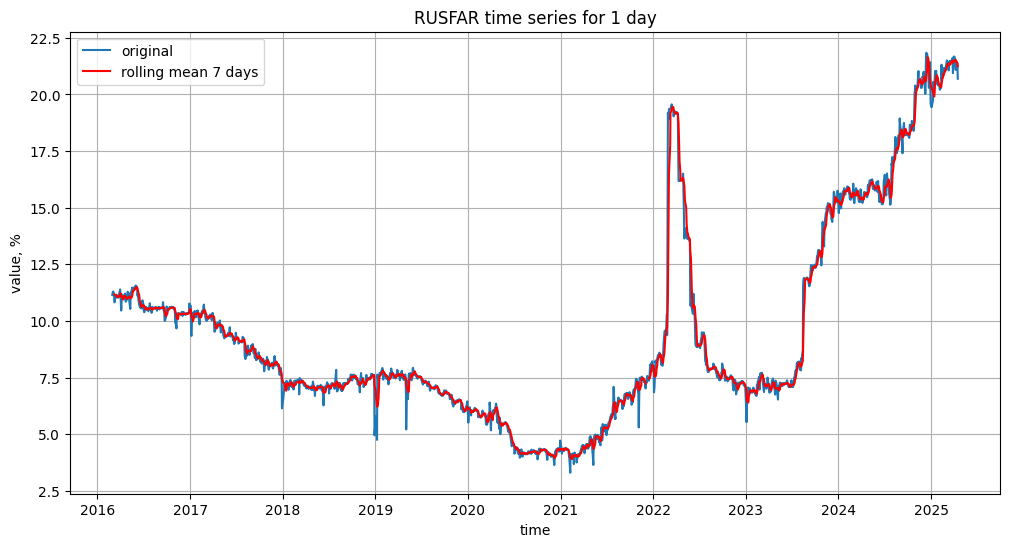

In [64]:
plt.figure(figsize=(12,6))
plt.plot(ksu_1d_preprocessed['date'], ksu_1d_preprocessed['ksu_waprice'], label='original')
plt.plot(ksu_1d_preprocessed['date'], ksu_1d_preprocessed['ksu_waprice'].rolling(7).mean(), label='rolling mean 7 days', color='red')
plt.title('RUSFAR time series for 1 day')
plt.xlabel('time')
plt.ylabel('value, %')
plt.legend()
plt.grid()

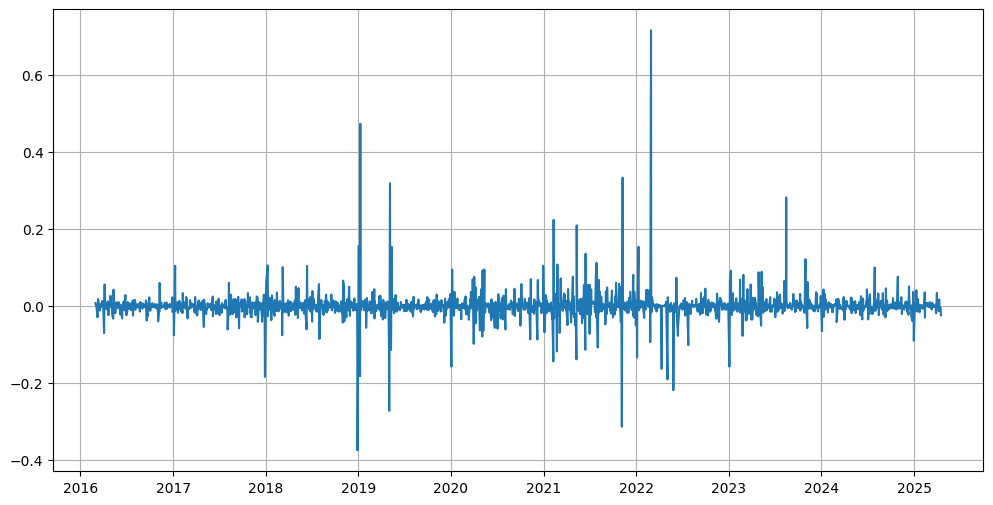

In [65]:
plt.figure(figsize=(12,6))
plt.plot(ksu_1d_preprocessed['date'], np.log(ksu_1d_preprocessed['ksu_waprice']).diff(), label='original')
plt.grid()

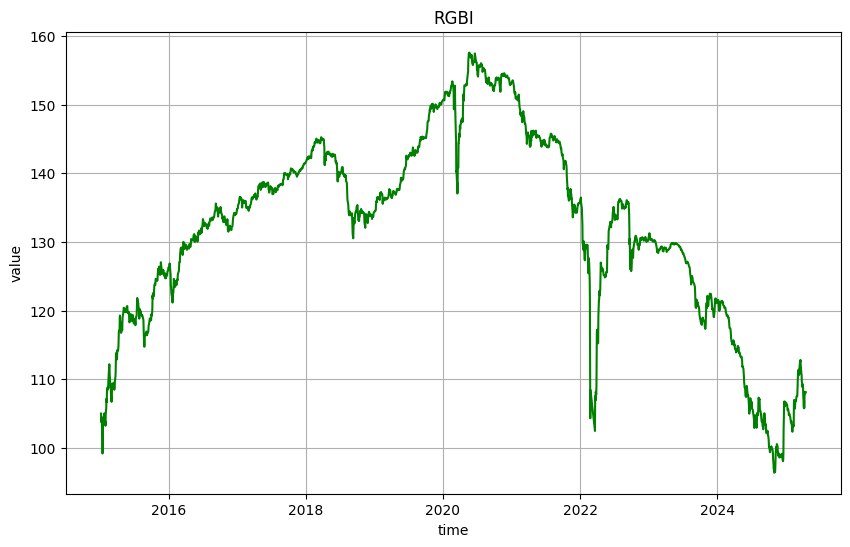

In [66]:
plt.figure(figsize=(10,6))
plt.plot(rgbi_preprocessed['date'], rgbi_preprocessed['rgbi_close'], color='green')
plt.title('RGBI')
plt.xlabel('time')
plt.ylabel('value')
plt.grid()

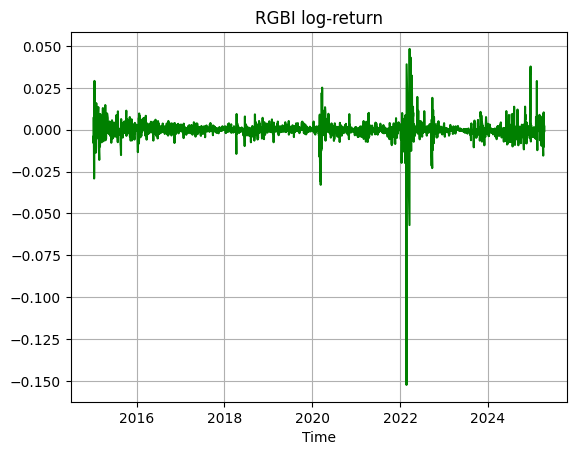

In [67]:
plt.plot(rgbi_preprocessed['date'], np.log(rgbi_preprocessed['rgbi_close']).diff(), color='green')
plt.xlabel('Time')
plt.title('RGBI log-return')
plt.grid()

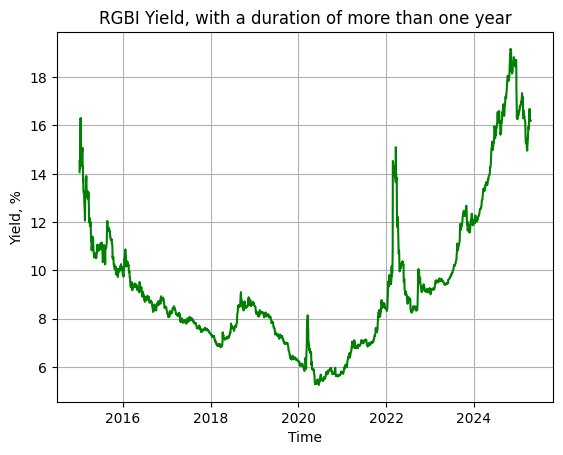

In [68]:
plt.plot(rgbi_preprocessed['date'], rgbi_preprocessed['rgbi_yield'], color='green')
plt.xlabel('Time')
plt.title('RGBI Yield, with a duration of more than one year')
plt.ylabel('Yield, %')
plt.grid()

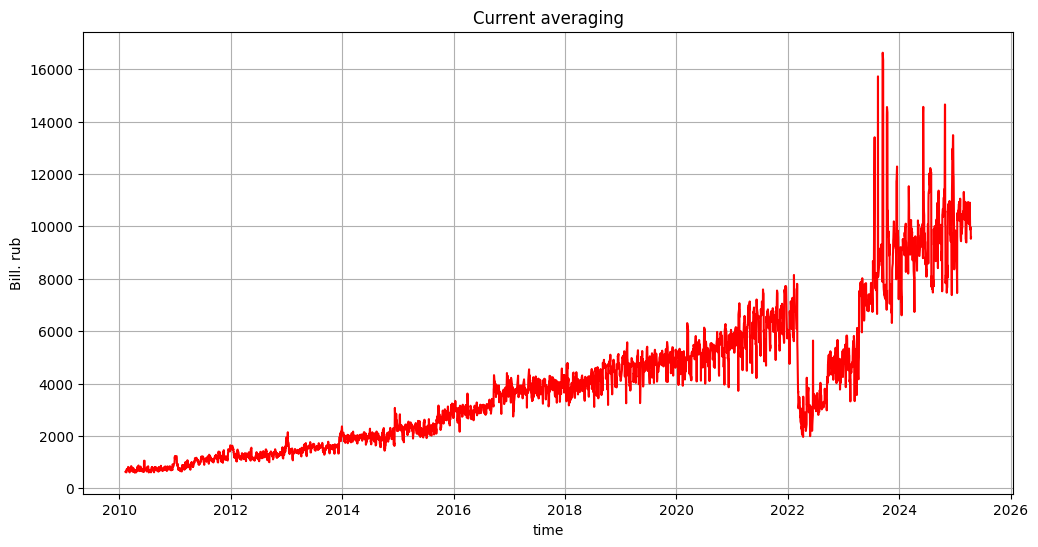

In [69]:
plt.figure(figsize=(12,6))
plt.plot(current_averaging['date'], current_averaging['current_averaging'], color='red')
plt.title('Current averaging')
plt.xlabel('time')
plt.ylabel('Bill. rub')
plt.grid()

In [70]:
proficit_deficit_liquidity_data.columns

Index(['date', 'liq_deficit', 'liq_deficit_excl_cor_accs'], dtype='object')

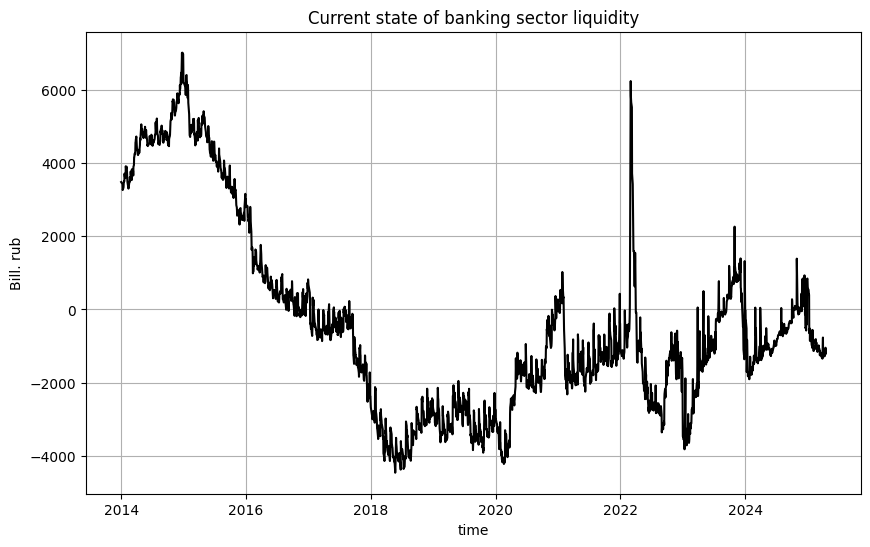

In [71]:
plt.figure(figsize=(10,6))
plt.plot(proficit_deficit_liquidity_data['date'], proficit_deficit_liquidity_data['liq_deficit'], color='black')
plt.title('Current state of banking sector liquidity')
plt.xlabel('time')
plt.ylabel('Bill. rub')
plt.grid()

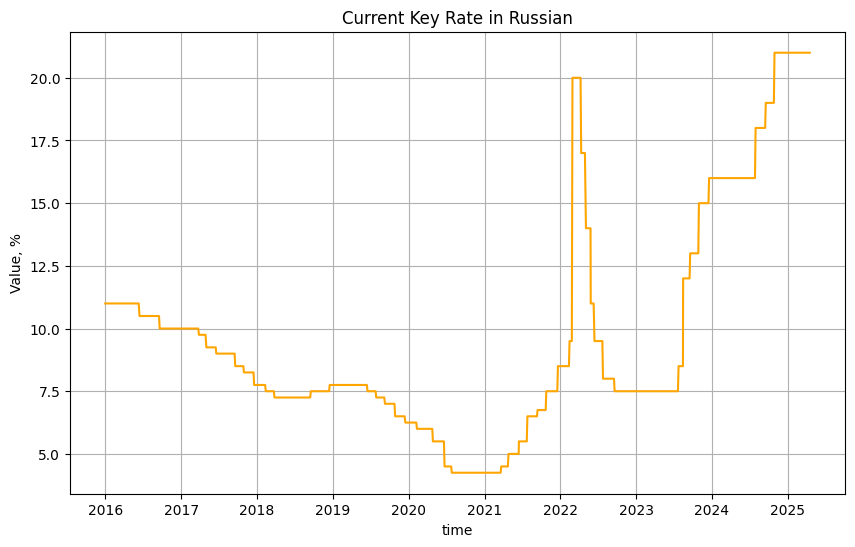

In [73]:
plt.figure(figsize=(10,6))
plt.plot(df_keyrate['date'], df_keyrate['KeyRate'], color='orange')
plt.title('Current Key Rate in Russian')
plt.xlabel('time')
plt.ylabel('Value, %')
plt.grid()

# Preprocessing and merging

In [74]:
df_preprocessed = ksu_1d_preprocessed.merge(proficit_deficit_liquidity_data, how='left', on='date')
df_preprocessed = df_preprocessed.merge(roisfix, how='left', on='date') # roisfix
df_preprocessed = df_preprocessed.merge(current_averaging, how='left', on='date') # тек. усреднее 
df_preprocessed = df_preprocessed.merge(rgbi_preprocessed, how='left', on='date') # RGBI
df_preprocessed = df_preprocessed.merge(df_keyrate, how='left', on='date') # Key rate

In [75]:
df_preprocessed.head()

,date,ksu_numtrades,ksu_volume,ksu_waprice,avg_per_trade_volume,liq_deficit,liq_deficit_excl_cor_accs,roisfix_1w,roisfix_1m,Funds_of_CI_on_CBR,mand_res_avg_cor_accs,current_averaging,rgbi_close,rgbi_volume,rgbi_yield,KeyRate
0,2016-02-29,13,332000000,11.14,2.553846e+07,1606.5,1522.2,10.88,10.88,1331.9,1416.2,2748.1,127.04,4.574518e+09,9.70,11.0
1,2016-03-01,5,155000000,11.23,3.100000e+07,1564.4,1921.7,10.99,10.94,1773.5,1416.2,3189.7,127.92,2.240770e+10,9.56,11.0
2,2016-03-02,5,126048000,11.27,2.520960e+07,1329.8,1470.9,10.99,10.94,1557.3,1416.2,2973.5,128.42,6.593708e+09,9.46,11.0
3,2016-03-03,2,90000000,11.29,4.500000e+07,1299.5,1355.2,10.91,10.88,1471.9,1416.2,2888.1,128.58,4.593268e+09,9.38,11.0
4,2016-03-04,1,85000000,11.30,8.500000e+07,1249.1,1358.3,10.87,10.86,1525.4,1416.2,2941.6,128.98,5.675131e+09,9.33,11.0


<Axes: >

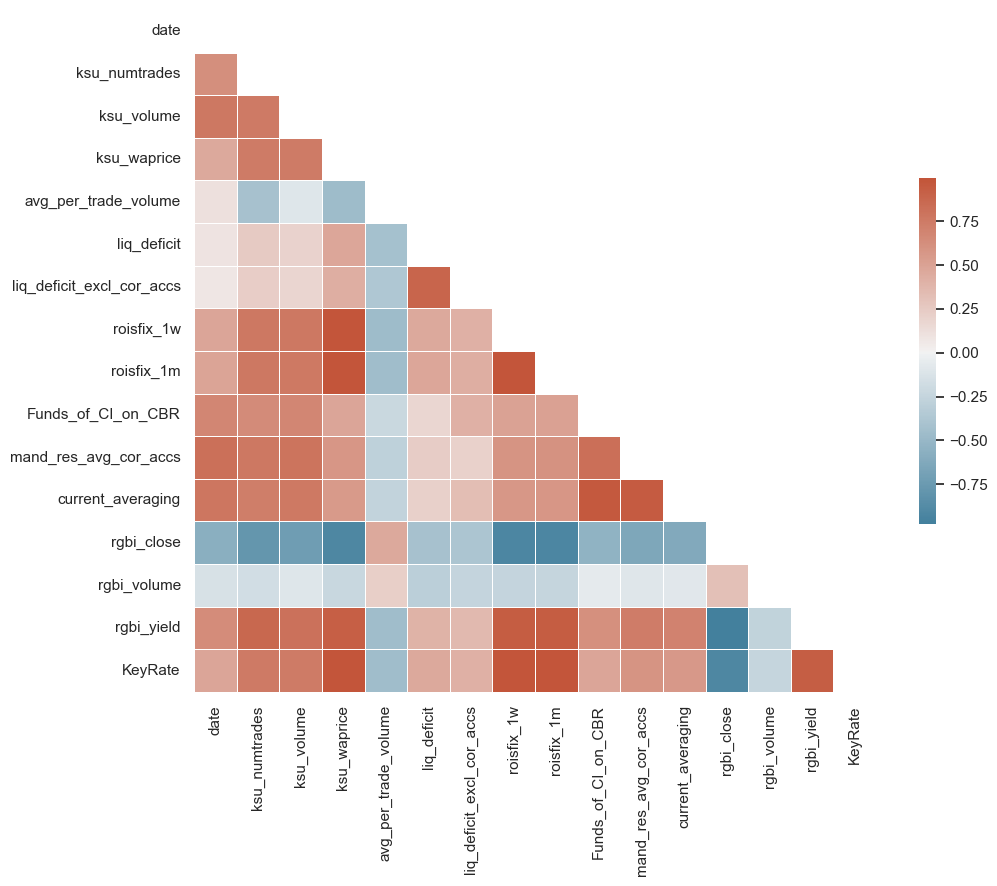

In [76]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset

# Compute the correlation matrix
corr = df_preprocessed.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Under 02.2022

In [89]:
df_preprocessed_under_24_02_2022 = df_preprocessed.copy()
df_preprocessed_under_24_02_2022 = df_preprocessed_under_24_02_2022.loc[df_preprocessed_under_24_02_2022['date'] <= '2022.02.25']
df_preprocessed_under_24_02_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512 entries, 0 to 1511
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       1512 non-null   datetime64[ns]
 1   ksu_numtrades              1512 non-null   int64         
 2   ksu_volume                 1512 non-null   int64         
 3   ksu_waprice                1511 non-null   float64       
 4   avg_per_trade_volume       1511 non-null   float64       
 5   liq_deficit                1478 non-null   float64       
 6   liq_deficit_excl_cor_accs  1478 non-null   float64       
 7   roisfix_1w                 1472 non-null   float64       
 8   roisfix_1m                 1472 non-null   float64       
 9   Funds_of_CI_on_CBR         1478 non-null   float64       
 10  mand_res_avg_cor_accs      1478 non-null   float64       
 11  current_averaging          1478 non-null   float64       
 12  rgbi_close 

In [90]:
# df_preprocessed_under_24_02_2022.drop(columns=['cbr_liq_ops'], inplace=True)
df_preprocessed_under_24_02_2022.dropna(inplace=True)
df_preprocessed_under_24_02_2022.describe()

,date,ksu_numtrades,ksu_volume,ksu_waprice,avg_per_trade_volume,liq_deficit,liq_deficit_excl_cor_accs,roisfix_1w,roisfix_1m,Funds_of_CI_on_CBR,mand_res_avg_cor_accs,current_averaging,rgbi_close,rgbi_volume,rgbi_yield,KeyRate
count,1470,1470.000000,1.470000e+03,1470.000000,1.470000e+03,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1.470000e+03,1470.000000,1470.000000
mean,2019-02-23 03:30:36.734693888,288.506803,8.688416e+10,7.425585,2.425814e+08,-1694.844422,-1605.288027,7.369007,7.379837,2362.540000,2273.908299,4636.448299,141.201639,1.829895e+10,7.521558,7.487755
min,2016-02-29 00:00:00,1.000000,8.500000e+07,3.300000,1.950880e+07,-4460.100000,-5026.500000,0.000000,0.000000,894.700000,1380.100000,2595.700000,104.300000,6.063031e+08,5.260000,4.250000
25%,2017-08-23 06:00:00,103.750000,1.898271e+10,6.050000,1.516796e+08,-3041.475000,-2955.600000,6.082500,6.080000,1870.900000,1874.400000,3814.500000,135.237500,9.935643e+09,6.870000,6.250000
50%,2019-02-20 12:00:00,328.000000,8.956543e+10,7.300000,2.616991e+08,-1704.700000,-1578.400000,7.330000,7.380000,2281.950000,2272.800000,4542.400000,140.195000,1.535164e+10,7.580000,7.500000
75%,2020-08-27 18:00:00,413.000000,1.323532e+11,8.897500,3.228314e+08,-439.900000,-294.325000,8.930000,8.930000,2709.100000,2633.900000,5298.275000,145.427500,2.355842e+10,8.390000,9.000000
max,2022-02-25 00:00:00,1268.000000,3.617520e+11,11.560000,6.263399e+08,1764.000000,2055.000000,10.990000,11.480000,4840.100000,3304.600000,8144.700000,157.550000,9.996340e+10,14.530000,11.000000
std,NaN,177.408002,6.515851e+10,2.056440,1.198098e+08,1479.074936,1522.678803,1.977925,1.985985,660.277287,502.305132,1092.855569,7.569586,1.213670e+10,1.104003,1.952055


In [91]:
df_preprocessed_under_24_02_2022.sort_values(by='date', inplace=True)

In [92]:
df_preprocessed_under_24_02_2022 = df_preprocessed_under_24_02_2022[['liq_deficit',
       'liq_deficit_excl_cor_accs', 'Funds_of_CI_on_CBR',
       'mand_res_avg_cor_accs', 'current_averaging',
       'rgbi_volume', 'rgbi_yield', 'ksu_numtrades', 'ksu_volume', 'avg_per_trade_volume',
       'ksu_waprice', 'KeyRate']]

In [93]:
# df_preprocessed_under_24_02_2022['log_current_averaging'] = np.log(df_preprocessed_under_24_02_2022['current_averaging']).diff()

## After 02.2022

In [94]:
df_preprocessed_after_24_02_2022 = df_preprocessed.copy().drop(columns=['rgbi_close'])
df_preprocessed_after_24_02_2022 = df_preprocessed_after_24_02_2022.loc[df_preprocessed_after_24_02_2022['date'] > '2022.02.25']
df_preprocessed_after_24_02_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 795 entries, 1512 to 2306
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       795 non-null    datetime64[ns]
 1   ksu_numtrades              795 non-null    int64         
 2   ksu_volume                 795 non-null    int64         
 3   ksu_waprice                795 non-null    float64       
 4   avg_per_trade_volume       795 non-null    float64       
 5   liq_deficit                794 non-null    float64       
 6   liq_deficit_excl_cor_accs  794 non-null    float64       
 7   roisfix_1w                 777 non-null    float64       
 8   roisfix_1m                 777 non-null    float64       
 9   Funds_of_CI_on_CBR         784 non-null    float64       
 10  mand_res_avg_cor_accs      784 non-null    float64       
 11  current_averaging          784 non-null    float64       
 12  rgbi_volu

In [95]:
df_preprocessed_after_24_02_2022 = df_preprocessed_after_24_02_2022.dropna()

In [96]:
df_preprocessed_after_24_02_2022.describe()

,date,ksu_numtrades,ksu_volume,ksu_waprice,avg_per_trade_volume,liq_deficit,liq_deficit_excl_cor_accs,roisfix_1w,roisfix_1m,Funds_of_CI_on_CBR,mand_res_avg_cor_accs,current_averaging,rgbi_volume,rgbi_yield,KeyRate
count,764,764.000000,7.640000e+02,764.000000,7.640000e+02,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,7.640000e+02,764.000000,764.000000
mean,2023-10-02 20:57:10.366492416,5716.693717,5.598591e+11,13.258325,2.177703e+08,-1053.382461,-981.292539,13.520955,13.653940,3757.617801,3690.402225,7448.020026,9.699475e+09,12.405798,13.541885
min,2022-03-21 00:00:00,498.000000,1.415068e+11,6.690000,2.681800e+07,-3820.100000,-4772.800000,7.320000,7.410000,664.300000,1283.100000,1960.800000,1.310908e+09,8.250000,7.500000
25%,2022-12-20 18:00:00,838.250000,3.034316e+11,7.595000,7.372881e+07,-1607.975000,-1886.550000,7.560000,7.600000,2354.550000,2323.300000,4746.000000,5.371260e+09,9.507500,7.500000
50%,2023-09-30 12:00:00,3515.000000,4.812633e+11,14.460000,1.989764e+08,-1068.800000,-1126.250000,14.845000,14.920000,3763.600000,4503.900000,7885.850000,8.113849e+09,11.915000,15.000000
75%,2024-07-12 18:00:00,8886.250000,6.561275e+11,17.015000,3.259579e+08,-313.775000,-452.375000,17.570000,17.830000,4882.500000,4746.300000,9617.175000,1.165858e+10,15.620000,18.000000
max,2025-04-16 00:00:00,18384.000000,1.831553e+12,21.840000,8.385891e+08,2262.300000,7838.500000,22.630000,23.400000,12127.500000,5181.700000,16631.400000,8.388473e+10,19.170000,21.000000
std,NaN,5873.113671,3.440073e+11,5.070553,1.570307e+08,1095.970630,1516.655953,5.102634,5.220868,1744.222243,1337.979912,2894.391509,7.119318e+09,3.207291,5.069977


# Define models

In [97]:
class EnhancedESN_FAN:
    def __init__(self,
                 input_dim,
                 reservoir_size=100,
                 spectral_radius=0.9,
                 sparsity=0.1,
                 ridge_alpha=1.0,
                 poly_order=2,
                 fan_dp=5,
                 seed=23):
        """
        input_dim : dimensionality of X (features per timestep)
        fan_dp    : number of Fourier terms (dp in the FAN paper)
        """
        np.random.seed(seed)
        self.reservoir_size = reservoir_size
        self.poly = PolynomialFeatures(degree=poly_order, include_bias=False)
        self.fan_dp = fan_dp

        # placeholders; actual Win/W init happens in fit()
        self.Win = None
        self.W   = None

        self.spectral_radius = spectral_radius
        self.sparsity = sparsity

        self.ridge = Ridge_sklearn(alpha=ridge_alpha)
        self.scaler = StandardScaler()
        self.input_scaler = StandardScaler()

    def initialize_weights(self, X):
        # input‐distribution aware Win
        inp_mean, inp_std = X.mean(axis=0), X.std(axis=0)
        mu, sigma = inp_mean.mean(), inp_std.mean()
        self.Win = np.random.normal(mu, sigma, (self.reservoir_size, X.shape[1] + 1))

        # sparse W with spectral radius
        W = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        W[np.random.rand(*W.shape) > self.sparsity] = 0
        W *= self.spectral_radius / np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W

    def _update(self, state, u):
        # standard ESN update
        pre = self.Win @ np.concatenate(([1], u)) + self.W @ state
        return np.tanh(pre)

    def _fourier_features(self, X):
        # X: (n_samples, n_features)
        # return: (n_samples, 2*fan_dp*n_features)
        # FAN: explicit Fourier series terms sin(2πk x), cos(2πk x)
        features = []
        for k in range(1, self.fan_dp + 1):
            features.append(np.sin(2 * np.pi * k * X))
            features.append(np.cos(2 * np.pi * k * X))
        return np.hstack(features)
    
    # def _fft_features(self, X, n_coeffs):
    #     # X: (T, n) time series
    #     # return first n_coeffs magnitudes per dimension
    #     coeffs = np.abs(fft(X, axis=0))[:n_coeffs]  # shape (n_coeffs, n)
    #     return np.tile(coeffs.flatten(), (X.shape[0], 1))

    def fit(self, X, y):
        """
        X: shape (T, input_dim)
        y: shape (T,) or (T, output_dim)
        """
        # init reservoir
        self.initialize_weights(X)

        # collect reservoir states
        T = X.shape[0]
        states = np.zeros((T, self.reservoir_size))
        state = np.zeros(self.reservoir_size)
        for t in range(T):
            state = self._update(state, X[t])
            states[t] = state

        X_scaled = self.input_scaler.fit_transform(X)
        # polynomial features
        P = self.poly.fit_transform(X_scaled)
        # Fourier analysis network features
        F = self._fourier_features(X_scaled)

        # # combine all
        # H = np.hstack([states, P, F])

        # # scale & fit readout
        # Hs = self.scaler.fit_transform(H)
        # self.ridge.fit(Hs, y)

        H = np.hstack([states, P, F])
        self.scaler.fit(H)
        # prevent division by zero in .transform()
        self.scaler.scale_[self.scaler.scale_ == 0.0] = 1.0
        Hs = self.scaler.transform(H)
        self.ridge.fit(Hs, y)


    def predict(self, X, generative_steps=None):
        """
        If X is (T, input_dim) and generative_steps is None, this is open-loop:
          returns readout(X)
        If generative_steps is an int > 0, we perform:
          - use X[-1] as u0, then recursively predict next u's.
        """
        if generative_steps is None:
            # one‐shot prediction (teacher forcing)
            T = X.shape[0]
            states = np.zeros((T, self.reservoir_size))
            state = np.zeros(self.reservoir_size)
            for t in range(T):
                state = self._update(state, X[t])
                states[t] = state

            P = self.poly.transform(X)
            F = self._fourier_features(X)
            H = np.hstack([states, P, F])
            Hs = self.scaler.transform(H)
            return self.ridge.predict(Hs)

        # generative forecasting
        u = X[-1].copy()      # last observed input
        state = np.zeros(self.reservoir_size)
        preds = []
        for _ in range(generative_steps):
            state = self._update(state, u.reshape(-1))
            # build feature row
            # P = self.poly.transform(u.reshape(1, -1))
            # F = self._fourier_features(u.reshape(1, -1))
            u_scaled = self.input_scaler.transform(u.reshape(1, -1))
            clip = 3.0  # you can tune this (e.g. 3 standard deviations)
            u_scaled = np.clip(u_scaled, -clip, clip)

            P = self.poly.transform(u_scaled)
            F = self._fourier_features(u_scaled)
            h = np.hstack([state, P.ravel(), F.ravel()]).reshape(1, -1)
            h_s = self.scaler.transform(h)
            u_next = self.ridge.predict(h_s)
            preds.append(u_next.ravel())
            u = u_next  # feed back

        return np.vstack(preds)

In [ ]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 23

In [ ]:
def reset_esn(input_dim):
    input_one = Input(input_dim=input_dim)
    reservoir_one = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                        lr=leak_rate, rc_connectivity=connectivity,
                        input_connectivity=input_connectivity, seed=seed)
    
    reservoir_2 = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                    lr=leak_rate, rc_connectivity=connectivity,
                    input_connectivity=input_connectivity, seed=seed)

    readout_one = Ridge(input_dim, ridge=regularization)

    return input_one >> reservoir_one >> reservoir_2 >> readout_one

# Cross-validation

# One-dimensional

In [98]:
def cross_validation(
    model_factory,
    time_series,
    time_delta,
    cv_type="expanding",
    train_size=None,
    drop_step=None,
    train_full=True
):
    """
    Perform multi‐step MAPE CV on a 1D series with either expanding or rolling windows,
    working directly on the provided real‐scale time_series.

    Parameters
    ----------
    model_factory : callable
        Constructor for your model (e.g. EnhancedESN_FAN), must accept input_dim=1
        and implement .fit(X,y) and .run(u).
    time_series : pd.Series or 1D array
        The raw input sequence.
    time_delta : int
        Forecast horizon for each fold.
    cv_type : {"expanding","rolling"}
        "expanding": train=[0:fold*Δ], test=next Δ points.
        "rolling" : train=[start:start+window_size], test=next Δ points.
    window_size : int, optional
        Required if cv_type=="rolling". Fixed length of each training window.
    train_full : bool
        If True, refit on the entire series at the end and return that model.

    Returns
    -------
    final_model : object or None
        The model refit on the full series if train_full else None.
    history_mape : List[float]
        One MAPE per fold.
    """
    ts = np.asarray(time_series)
    L = len(time_series)

    if cv_type not in ("expanding", "rolling"):
        raise ValueError("cv_type must be 'expanding' or 'rolling'")

    if cv_type == "rolling" and drop_step is None:
        raise ValueError("Must specify window_size for rolling CV")
    
    history_mape = []
    history_mae = []

    if cv_type == "expanding":
        n_folds = (L-train_size) // time_delta
        F = (L-train_size) % time_delta  # Остаточная часть (конец ряда)
        for fold in range(0, n_folds+1):
            train_end = train_size + fold * time_delta
            test_start = train_end
            test_end   = train_end + time_delta
            if test_end > L:
                break

            # Build train and test slices
            X_tr = ts[:train_end-1].reshape(-1, 1)
            y_tr = ts[1:train_end].reshape(-1, 1)
            y_true = ts[test_start:test_end].reshape(-1, 1)

            # Fit model
            model = model_factory
            model.fit(X_tr, y_tr)

            # Generative Δ-step forecast
            preds = model.predict(y_tr, generative_steps=time_delta)
            
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_true, preds) * 100
            history_mape.append(mape)

            # Compute MAE
            mae = mean_absolute_error(y_true, preds)
            history_mae.append(mae)

        if F > 0:
            train_end = L - F
            test_start = train_end
            test_end = L  # Используем весь остаток

            X_tr = ts[:train_end - 1].reshape(-1, 1)
            y_tr = ts[1:train_end].reshape(-1, 1)
            y_true = ts[test_start:test_end].reshape(-1, 1)

            # Fit model
            model = model_factory
            model.fit(X_tr, y_tr)

            # Generative Δ-step forecast
            preds = model.predict(y_tr, generative_steps=F)
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_true, preds) * 100
            history_mape.append(mape)

            # Compute MAE
            mae = mean_absolute_error(y_true, preds)
            history_mae.append(mae)

    else:  # rolling
        for start in range(0, L-train_size-time_delta+1, drop_step):
            train_start = start
            train_end   = start+train_size+time_delta
            test_start  = train_end
            test_end    = test_start + time_delta
            if test_end > L:
                break

            X_tr = ts[train_start:train_end-1].reshape(-1, 1)
            y_tr = ts[train_start+1:train_end].reshape(-1, 1)
            y_true = ts[test_start:test_end].reshape(-1, 1)

            model = model_factory
            model.fit(X_tr, y_tr)

            preds = model.predict(y_tr, generative_steps=time_delta)
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_true, preds) * 100
            history_mape.append(mape)

            # Compute MAE
            mae = mean_absolute_error(y_true, preds)
            history_mae.append(mae)

    final_model = None
    if train_full:
        X_all = ts[:-1].reshape(-1,1)
        y_all = ts[1: ].reshape(-1,1)
        final_model = model_factory.fit(X_all, y_all)

    return final_model, history_mape, history_mae

## Multivariate

In [170]:
def cross_validation_multi(
    model_factory,
    time_series,
    time_delta,
    cv_type="expanding",
    train_size=None,
    train_full=False,
    drop_step=None
):
    """
    Perform multi-step MAPE cross-validation on multivariate time series,
    computing MAPE individually for each variable.

    Parameters
    ----------
    model_factory : callable
        Constructor for EnhancedESN_FAN, accepts input_dim and provides methods fit(X,y) and predict(X, generative_steps).
    time_series : pd.DataFrame or np.ndarray
        Multivariate series (shape: [T, num_features]).
    time_delta : int
        Forecast horizon per fold.
    cv_type : {"expanding", "rolling"}
        Cross-validation type.
    window_size : int, optional
        Training window size if rolling CV.
    train_full : bool
        Train on full data after CV if True.

    Returns
    -------
    final_model : object or None
        Model trained on full series if train_full else None.
    history_mape : dict
        Dict of variable-wise MAPE lists per fold.
    """
    ts = np.asarray(time_series)
    num_obs, num_features = ts.shape
    L = len(time_series)

    if cv_type not in ("expanding", "rolling"):
        raise ValueError("cv_type must be 'expanding' or 'rolling'")

    if cv_type == "rolling" and drop_step is None:
        raise ValueError("Must specify window_size for rolling CV")

    history_mape = {f"var_{i}": [] for i in range(num_features)}
    history_mae = {f"var_{i}": [] for i in range(num_features)}

    if cv_type == "expanding":
        n_folds = (L-train_size) // time_delta
        F = (L-train_size) % time_delta  # Остаточная часть (конец ряда)
        for fold in range(0, n_folds+1):
            train_end = train_size + fold * time_delta
            test_start = train_end
            test_end = train_end + time_delta

            if test_end > num_obs:
                break

            X_tr = ts[:train_end-1]
            y_tr = ts[1:train_end]
            y_true = ts[test_start:test_end]

            model = model_factory
            model.fit(X_tr, y_tr)

            preds = model.predict(y_tr, generative_steps=time_delta)

            for i in range(num_features):
                mape = mean_absolute_percentage_error(y_true[:, i], preds[:, i]) * 100
                history_mape[f"var_{i}"].append(mape)

                

        if F > 0:
            train_end = L - F
            test_start = train_end
            test_end = L  # Используем весь остаток

            X_tr = ts[:train_end - 1]
            y_tr = ts[1:train_end]
            y_true = ts[test_start:test_end]

            # Fit model
            model = model_factory
            model.fit(X_tr, y_tr)

            # Generative Δ-step forecast
            preds = model.predict(y_tr, generative_steps=F)
            # Compute MAPE
            for i in range(num_features):
                mape = mean_absolute_percentage_error(y_true[:, i], preds[:, i]) * 100
                history_mape[f"var_{i}"].append(mape)

                mae = mean_absolute_error(y_true[:, i], preds[:, i])
                history_mae[f"var_{i}"].append(mae)

    else:  # rolling
        for start in range(0, L-train_size-time_delta+1, drop_step):
            train_start = start
            train_end   = start+train_size+time_delta
            test_start  = train_end
            test_end    = test_start + time_delta
            if test_end > L:
                break

            X_tr = ts[train_start:train_end-1]
            y_tr = ts[train_start+1:train_end]
            y_true = ts[test_start:test_end]

            model = model_factory
            model.fit(X_tr, y_tr)

            preds = model.predict(y_tr, generative_steps=time_delta)
            # Compute MAPE
            for i in range(num_features):
                mape = mean_absolute_percentage_error(y_true[:, i], preds[:, i]) * 100
                history_mape[f"var_{i}"].append(mape)

                mae = mean_absolute_error(y_true[:, i], preds[:, i])
                history_mae[f"var_{i}"].append(mae)

    final_model = None
    if train_full:
        X_all = ts[:-1]
        y_all = ts[1:]
        final_model = model_factory
        final_model.fit(X_all, y_all)

    return final_model, history_mape, history_mae


In [160]:
esn_fan = EnhancedESN_FAN(input_dim=1, reservoir_size=200, spectral_radius=0.9,
                      sparsity=0.5, ridge_alpha=1e-8, poly_order=2, fan_dp=5, seed=23)

In [100]:
df_preprocessed_under_24_02_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 0 to 1511
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   liq_deficit                1470 non-null   float64
 1   liq_deficit_excl_cor_accs  1470 non-null   float64
 2   Funds_of_CI_on_CBR         1470 non-null   float64
 3   mand_res_avg_cor_accs      1470 non-null   float64
 4   current_averaging          1470 non-null   float64
 5   rgbi_volume                1470 non-null   float64
 6   rgbi_yield                 1470 non-null   float64
 7   ksu_numtrades              1470 non-null   int64  
 8   ksu_volume                 1470 non-null   int64  
 9   avg_per_trade_volume       1470 non-null   float64
 10  ksu_waprice                1470 non-null   float64
 11  KeyRate                    1470 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 149.3 KB


In [101]:
df_preprocessed_after_24_02_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 764 entries, 1525 to 2306
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       764 non-null    datetime64[ns]
 1   ksu_numtrades              764 non-null    int64         
 2   ksu_volume                 764 non-null    int64         
 3   ksu_waprice                764 non-null    float64       
 4   avg_per_trade_volume       764 non-null    float64       
 5   liq_deficit                764 non-null    float64       
 6   liq_deficit_excl_cor_accs  764 non-null    float64       
 7   roisfix_1w                 764 non-null    float64       
 8   roisfix_1m                 764 non-null    float64       
 9   Funds_of_CI_on_CBR         764 non-null    float64       
 10  mand_res_avg_cor_accs      764 non-null    float64       
 11  current_averaging          764 non-null    float64       
 12  rgbi_volu

In [161]:
model_one, one_history, one_history_mae = cross_validation(esn_fan, df_preprocessed_under_24_02_2022['ksu_waprice'].dropna(),
                                                            time_delta=14, train_size=365)

In [173]:
model_one_sch2, one_history_sch2, one_history_sch2_mae = cross_validation(esn_fan, df_preprocessed_under_24_02_2022['ksu_waprice'].dropna(),
                                                            cv_type='rolling', time_delta=14, train_size=365, drop_step=14)

--------------------------------------------------------------------------------------------------------------------------------------------------

In [163]:
esn_fan_multi = EnhancedESN_FAN(input_dim=6, reservoir_size=200, spectral_radius=0.9,
                      sparsity=0.5, ridge_alpha=1e-8, poly_order=2, fan_dp=3, seed=23)

In [103]:
df_preprocessed_under_24_02_2022.columns

Index(['liq_deficit', 'liq_deficit_excl_cor_accs', 'Funds_of_CI_on_CBR',
       'mand_res_avg_cor_accs', 'current_averaging', 'rgbi_volume',
       'rgbi_yield', 'ksu_numtrades', 'ksu_volume', 'avg_per_trade_volume',
       'ksu_waprice', 'KeyRate'],
      dtype='object')

In [164]:
model_multi, multi_history, multi_history_mae = cross_validation_multi(esn_fan_multi,
df_preprocessed_under_24_02_2022[['ksu_waprice', 'ksu_volume', 'rgbi_yield', 'rgbi_volume', 'liq_deficit', 'liq_deficit_excl_cor_accs']].dropna().values,
 time_delta=14, train_size=365)

In [174]:
model_multi_sch2, multi_history_sch2, multi_history_sch2_mae = cross_validation_multi(esn_fan_multi,
df_preprocessed_under_24_02_2022[['ksu_waprice', 'ksu_volume', 'rgbi_yield', 'rgbi_volume', 'liq_deficit', 'liq_deficit_excl_cor_accs']].dropna().values,
 cv_type='rolling', time_delta=14, train_size=365, drop_step=14)

# Box-Plots

## Expanding

(0.0, 5.0)

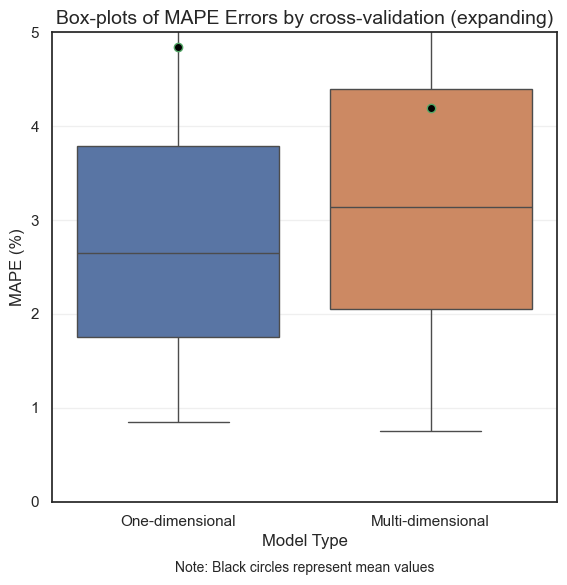

In [165]:
# Создаем DataFrame для визуализации
data = pd.DataFrame({
    'One-dimensional': np.array(one_history[:]),
    'Multi-dimensional': np.array(multi_history['var_0']),
})

# Преобразуем данные в длинный формат
data_melted = data.melt(var_name='Model', value_name='MAPE')

# Настраиваем размер графика
plt.figure(figsize=(6, 6))

# Рисуем boxplot
sns.boxplot(
    x='Model', 
    y='MAPE', 
    data=data_melted,
    hue='Model',
    legend=False,
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'black'}
)

# Добавляем заголовок и подписи
plt.title("Box-plots of MAPE Errors by cross-validation (expanding)", fontsize=14)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем аннотации
plt.text(
    x=0.5, y=-0.15, 
    s='Note: Black circles represent mean values',
    fontsize=10, ha='center', transform=plt.gca().transAxes
)

plt.tight_layout()
plt.ylim(0,5)

## Roling

(0.0, 5.0)

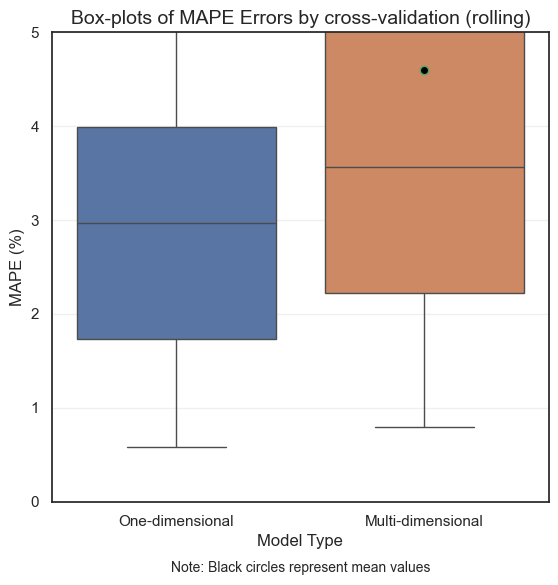

In [175]:
# Создаем DataFrame для визуализации
data = pd.DataFrame({
    'One-dimensional': np.array(one_history_sch2[:]),
    'Multi-dimensional': np.array(multi_history_sch2['var_0']),
})

# Преобразуем данные в длинный формат
data_melted = data.melt(var_name='Model', value_name='MAPE')

# Настраиваем размер графика
plt.figure(figsize=(6, 6))

# Рисуем boxplot
sns.boxplot(
    x='Model', 
    y='MAPE', 
    data=data_melted,
    hue='Model',
    legend=False,
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'black'}
)

# Добавляем заголовок и подписи
plt.title("Box-plots of MAPE Errors by cross-validation (rolling)", fontsize=14)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем аннотации
plt.text(
    x=0.5, y=-0.15, 
    s='Note: Black circles represent mean values',
    fontsize=10, ha='center', transform=plt.gca().transAxes
)

plt.tight_layout()
plt.ylim(0,5)